<font color='red'>Important note:</font>
This homework is designed to run on colab with T4 gpu, as it requires at least 15Gb of *VRAM*, 12Gb of *RAM* and `sudo` access.

# Installing the Dependencies

In [ ]:
%%capture
!pip install transformers==4.35.0
!pip install sentencepiece==0.1.99
!pip install datasets==2.14.6
!pip install accelerate==0.24.1
!pip install Ninja==1.11.1.1

### Imports

In [ ]:
import os
import math
import time
import random
from tqdm.notebook import tqdm, trange
from typing import Callable
import matplotlib.pyplot as plt

import torch
from torch import Tensor
from torch import nn
import torch.nn.functional as F

import transformers
from transformers.models.llama.modeling_llama import LlamaDecoderLayer, LlamaForCausalLM
from transformers.models.llama.configuration_llama import LlamaConfig
from transformers import AutoTokenizer
from datasets import load_dataset
import accelerate

# Quantization Reduces Memory Footprint

In [ ]:
def measure_bits_per_coordinate(size: int, dtype: torch.dtype):
    torch.cuda.empty_cache()
    baseline = torch.cuda.memory_allocated() * 8
    tensor = torch.empty((size,), dtype=dtype, device="cuda")
    allocated = torch.cuda.memory_allocated() * 8
    return (allocated - baseline) / size

print(f"float16: {measure_bits_per_coordinate(4096, torch.float16):.0f}")
print(f"int8: {measure_bits_per_coordinate(4096, torch.int8):.0f}")

float16: 16
int8: 8


In this notebook, we'll be working with `LLaMA-7b` model, that contains 7 billion parameters. In `float16`, that would amount to about *14 Gb* of model weigts. The colab *GPU* can barely fit it, and it's not nearly enought to run it on long sequences. Moreover, we want to be able to put the model in *RAM*, to have more *VRAM* available to hold activations and conduct memory-heavy quantization operations.

However, quantizing the linear layers we can greatly decrease the model size. The function below calculates the model footprint, if we quantize all the `nn.Linear` layers to `bits` bits.

In [ ]:
LLAMA_REPO = "yahma/llama-7b-hf"


def measure_model_footrpint(model: nn.Module, bits: int):
    memory_footpring = 0
    if isinstance(model, nn.Linear):
        memory_footpring = bits * model.weight.data.numel()
    elif len(list(model.children())) == 0:
        for p in model.parameters():
            memory_footpring += p.data.numel() * 16

    for name, child in model.named_children():
        memory_footpring += measure_model_footrpint(child, bits)

    return memory_footpring


with accelerate.init_empty_weights():
    model = LlamaForCausalLM(LlamaConfig.from_pretrained(LLAMA_REPO))

llama_size_fp16_gb = measure_model_footrpint(model, 16) * 2 ** (-33)
llama_size_int8_gb = measure_model_footrpint(model, 8) * 2 ** (-33)
llama_size_int4_gb = measure_model_footrpint(model, 4) * 2 ** (-33)

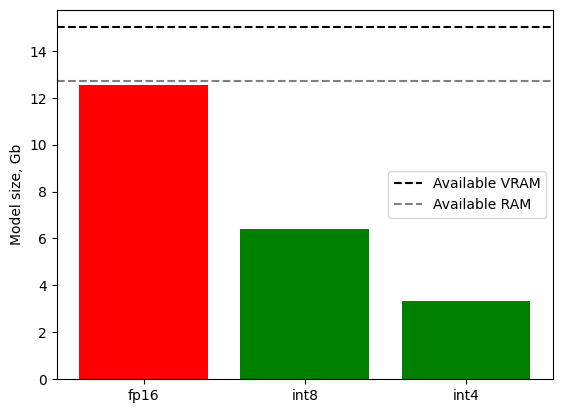

In [ ]:
dtypes = ['fp16', 'int8', 'int4']
sizes = [llama_size_fp16_gb, llama_size_int8_gb, llama_size_int4_gb]
bar_colors = ['red', 'green', 'green']

plt.bar(dtypes, sizes, color=bar_colors)
plt.ylabel("Model size, Gb")
plt.axhline(15.0, linestyle="--", color="black", label="Available VRAM")
plt.axhline(12.7, linestyle="--", color="gray", label="Available RAM")
plt.legend()
plt.show()

As we can see, we can easily fit the quantized model into both RAM and VRAM.

# Quantized Tensors are Faster to Multiply

In [ ]:
@torch.no_grad()
def benchmark_multiplication(batch_size: int, input_size: int, output_size: int, n_repeats: int, dtype: torch.dtype, matmul_fn: Callable[[Tensor, Tensor], Tensor], device:torch.device="cuda"):
    weight = torch.empty((output_size, input_size), dtype=dtype, device=device) # notice that output_size is first
    input = torch.empty((batch_size, input_size), dtype=dtype, device=device)

    # Preheat
    # YOUR CODE HERE>>>>>>>>>
    for i in range(n_repeats):
        _ = matmul_fn(input, weight)
    # <<<<<<<<<<<<<<<<<<<<<<<

    start = time.time()
    # YOUR CODE HERE>>>>>>>>>
    for i in range(n_repeats):
        _ = matmul_fn(input, weight)
    # <<<<<<<<<<<<<<<<<<<<<<<
    torch.cuda.synchronize()
    end = time.time()

    return end - start


### Int-4 multiplication

Torch doesn't navtively support Int4 multiplication. We'll have to write our own GPU multiplication kernels, using CUDA toolkit and cutlass.

**Install CUDA 12.3**

In [ ]:
%%capture
!wget https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64/cuda-ubuntu2204.pin
!sudo mv cuda-ubuntu2204.pin /etc/apt/preferences.d/cuda-repository-pin-600
!wget https://developer.download.nvidia.com/compute/cuda/12.3.0/local_installers/cuda-repo-ubuntu2204-12-3-local_12.3.0-545.23.06-1_amd64.deb
!sudo dpkg -i cuda-repo-ubuntu2204-12-3-local_12.3.0-545.23.06-1_amd64.deb
!sudo cp /var/cuda-repo-ubuntu2204-12-3-local/cuda-*-keyring.gpg /usr/share/keyrings/
!sudo apt-get update
!sudo apt-get -y install cuda-toolkit-12-3
!pip install --upgrade pip

**Download cutlass**

In [ ]:
%%capture

!git clone https://github.com/NVIDIA/cutlass.git
!export CUDACXX=/usr/local/cuda/bin/nvcc
!cd cutlass && mkdir build && cd build && cmake .. -DCUTLASS_NVCC_ARCHS=75

**Writing custom cuda kernels**

In [ ]:
from torch.utils.cpp_extension import load

kernel_cpp = """#include <torch/extension.h>

torch::Tensor int4MatmulCUDA(const torch::Tensor &A, const torch::Tensor &B);

torch::Tensor int8MatmulCUDA(const torch::Tensor &A, const torch::Tensor &B);

torch::Tensor int4Matmul(const torch::Tensor &A, const torch::Tensor &B) {
  torch::checkAllContiguous("int4Matmul", {{A, "A", 0}, {B, "B", 1}});
  torch::checkDeviceType("int4Matmul", {A, B}, at::DeviceType::CUDA);
  return int4MatmulCUDA(A, B);
}

torch::Tensor int8Matmul(const torch::Tensor &A, const torch::Tensor &B) {
  torch::checkAllContiguous("int8Matmul", {{A, "A", 0}, {B, "B", 1}});
  torch::checkDeviceType("int8Matmul", {A, B}, at::DeviceType::CUDA);
  return int8MatmulCUDA(A, B);
}

PYBIND11_MODULE(TORCH_EXTENSION_NAME, m) {
  m.def("int4_matmul", &int4Matmul, "int4 matmul (CUDA)");
  m.def("int8_matmul", &int8Matmul, "int8 matmul (CUDA)");
}
"""

with open("kernel.cpp", "w") as file:
    file.write(kernel_cpp)


kernel_cu = """#include <torch/extension.h>

#include <cuda.h>
#include <cuda_runtime.h>

#include <cutlass/gemm/device/gemm.h>


torch::Tensor int4MatmulCUDA(const torch::Tensor &A, const torch::Tensor &B) {
  torch::checkAllSameGPU("int4Matmul", {{A, "A", 0}, {B, "B", 1}});
  auto M = A.size(0);
  auto N = B.size(0);
  auto K = A.size(1) * 2;  // 4bit packing is on the columns
  auto C = torch::empty({M, N}, torch::dtype(torch::kInt32).device(A.device()));

  using Gemm = cutlass::gemm::device::Gemm<
      cutlass::int4b_t,                // ElementA
      cutlass::layout::RowMajor,       // LayoutA
      cutlass::int4b_t,                // ElementB
      cutlass::layout::ColumnMajor,    // LayoutB
      int32_t,                         // ElementOutput
      cutlass::layout::RowMajor,       // LayoutOutput
      int32_t,                         // ElementAccumulator
      cutlass::arch::OpClassTensorOp,  // tag indicating Tensor Cores
      cutlass::arch::Sm75  // tag indicating target GPU compute architecture
      >;

  Gemm gemmOp;

  using GemmCoord = cutlass::gemm::GemmCoord;

  typename Gemm::Arguments arguments{
      {static_cast<GemmCoord::Index>(M), static_cast<GemmCoord::Index>(N),
       static_cast<GemmCoord::Index>(K)},
      {(cutlass::int4b_t *)A.data_ptr<uint8_t>(), K},
      {(cutlass::int4b_t *)B.data_ptr<uint8_t>(), K},
      {C.data_ptr<int32_t>(), N},
      {C.data_ptr<int32_t>(), N},
      {1, 0}};

  auto status = gemmOp(arguments);

  TORCH_CHECK(status == cutlass::Status::kSuccess,
              cutlassGetStatusString(status))

  return C;
}

torch::Tensor int8MatmulCUDA(const torch::Tensor &A, const torch::Tensor &B) {
  torch::checkAllSameGPU("int8Matmul", {{A, "A", 0}, {B, "B", 1}});
  auto M = A.size(0);
  auto N = B.size(0);
  auto K = A.size(1);  // 4bit packing is on the columns
  auto C = torch::empty({M, N}, torch::dtype(torch::kInt32).device(A.device()));

  using Gemm = cutlass::gemm::device::Gemm<
      int8_t,                          // ElementA
      cutlass::layout::RowMajor,       // LayoutA
      int8_t,                          // ElementB
      cutlass::layout::ColumnMajor,    // LayoutB
      int32_t,                         // ElementOutput
      cutlass::layout::RowMajor,       // LayoutOutput
      int32_t,                         // ElementAccumulator
      cutlass::arch::OpClassTensorOp,  // tag indicating Tensor Cores
      cutlass::arch::Sm75  // tag indicating target GPU compute architecture
      >;

  Gemm gemmOp;

  using GemmCoord = cutlass::gemm::GemmCoord;

  typename Gemm::Arguments arguments{
      {static_cast<GemmCoord::Index>(M), static_cast<GemmCoord::Index>(N),
       static_cast<GemmCoord::Index>(K)},
      {A.data_ptr<int8_t>(), K},
      {B.data_ptr<int8_t>(), K},
      {C.data_ptr<int32_t>(), N},
      {C.data_ptr<int32_t>(), N},
      {1, 0}};

  auto status = gemmOp(arguments);

  TORCH_CHECK(status == cutlass::Status::kSuccess,
              cutlassGetStatusString(status))

  return C;
}
"""

with open("kernel.cu", "w") as file:
    file.write(kernel_cu)

custom_kernel = load(name='custom_kernel', sources=['kernel.cpp', 'kernel.cu'], extra_include_paths=[r"cutlass/include"])

Usage: `output = custom_kernel.int8_matmul(...)`, `output = custom_kernel.int4_matmul(...)`

Notice that `int8_matmul` takes the normal `torch.int8` tensors, but int4_matmul expects `int4` values densely packed into `torch.uint8` tensors. Without goint into further detail, an `int4` matrix of size `A x B` would be represented by a `torch.uint8` tensor of shape `A x B//2`. Remember that when benchmarking the operations.

### Benchmarking matmul

In [ ]:
n_repeats = 256
batch_size = 1024
input_size = output_size = 4096

torch.cuda.empty_cache()
# YOUR CODE HERE>>>>>>>>>
fp16_ms = benchmark_multiplication(batch_size, input_size, output_size, n_repeats, torch.float16, torch.matmul) / n_repeats* 1000
int8_ms = benchmark_multiplication(batch_size, input_size, output_size, n_repeats, torch.int8, custom_kernel.int8_matmul) / n_repeats * 1000
int4_ms = benchmark_multiplication(batch_size, input_size // 2, output_size, n_repeats, torch.uint8, custom_kernel.int4_matmul) / n_repeats * 1000
# <<<<<<<<<<<<<<<<<<<<<<<

print(f"fp16: {fp16_ms:.2f} ms")
print(f"int8: {int8_ms:.2f} ms")
print(f"int4: {int4_ms:.2f} ms")

fp16: 2.24 ms
int8: 1.30 ms
int4: 0.70 ms


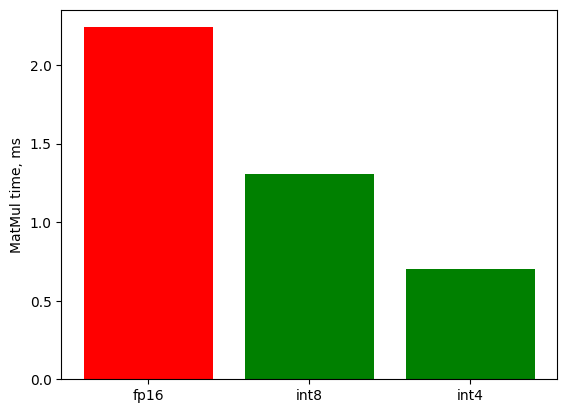

In [ ]:
dtypes = ['fp16', 'int8', 'int4']
times = [fp16_ms, int8_ms, int4_ms]
bar_colors = ['red', 'green', 'green']

plt.bar(dtypes, times, color=bar_colors)
plt.ylabel("MatMul time, ms")
plt.show()

# Quantizing Matrices Row-Wise

### Basic Quantization

**Mapping the values to the allowed range**

Quantization is the process of mapping input values from a large set to output values in a smaller set. For instance, if we consider 4-bit
quantization, our values are represented by $4$ bits, meaning we can represent values between 0 and $2^4-1=15$.

 * To produce the quantized representation, we need to be able to map the matrix values to and from this range.
 * For reasons that become important later, we will perform this mapping independently for each matrix row.
 * We will parametrize the mapping like this: $out = \frac{in}{scale} + zero$, where $scale$ and $zero$ are row-wise constants.
 * For a matrix of size `(m, k)` ($m$ rows, $k$ columns) we will aggregate those parameters into two vectors `scale` and `zero` of size `(m, 1)`.

**Task:** Complete the function below to perform this mapping:

In [ ]:
def get_scale_and_zero(x: Tensor, max_abs: float) -> tuple[Tensor, Tensor]:
    """ Given a tensor x of shape (m, k) and max_abs > 0 produce tensors scale and zero of shape (m, 1)
        such that 0 < x / scale + zero < max_abs"""
    # YOUR CODE HERE>>>>>>>>>
    xmin = x.min(-1)[0]
    xmax = x.max(-1)[0]

    xmin[xmin == xmax] = -1
    xmax[xmin == xmax] = +1

    scale = (xmax - xmin) / max_abs
    zero = -xmin / scale

    scale = scale.unsqueeze(-1)
    zero = zero.unsqueeze(-1)
    return scale.to(x.dtype), zero.to(x.dtype)
    # <<<<<<<<<<<<<<<<<<<<<<<


In [ ]:
# Testing your code

x = torch.arange(512 * 1024).reshape(512, 1024).float()
scale, zero = get_scale_and_zero(x, 15)

assert scale.shape == (512, 1), "scale is wrong shape"
assert zero.shape == (512, 1), "zero is wrong shape"
assert torch.all(scale * 15 <= 1023.1), "Scale can't be that large. The resulting interval is too wide"
assert torch.all(scale * 15 >= 1022.9), "Scale shouldn't be that small. The resulting interval is too narrow"
assert torch.all(-0.001 <  x / scale + zero) and torch.all(x / scale + zero < 15 + 0.001)
print("All tests passed!")

All tests passed!


**Quantization**

Having mapped the values into the allowed range, we can simply round them to obtain the quantized matrix. Complete the functions below to perform row-wise quantization. Note that:
 * `measure_and_quantize` takes the matrix `x` and `bits` - the number of bits to quantize to. Calculate the allowed quantized values range yourself (hint: look a few cells above).
 * Use `get_scale_and_zero` to obtain the layer-wise quantization constants, then use them to map the matrix values to the required range.
 * `torch.clamp(...)` the quantized values to ensure that they are in the range.
 * The function returns the quantized matrix, as well as the quantization constants, because we'll need them to dequantiza the matrix.

**Task:** Complete the function below to perform quantization:

In [ ]:
def quantize(x: Tensor, scale: Tensor, zero: Tensor, bits: int) -> Tensor:
    """Given a tensor x quantize it, producing tensors quantized_x"""
    # YOUR CODE HERE>>>>>>>>>
    max_abs = 2 ** bits - 1
    quantized_x = torch.round(x / scale + zero)
    quantized_x = torch.clamp(quantized_x, 0, max_abs)
    # <<<<<<<<<<<<<<<<<<<<<<<
    return quantized_x.to(torch.uint8)


def dequantize(x: Tensor, scale: Tensor, zero: Tensor) -> Tensor:
    # YOUR CODE HERE>>>>>>>>>
    return scale * x - scale * zero
    # <<<<<<<<<<<<<<<<<<<<<<<


def measure_and_quantize(x: Tensor, bits: float) -> tuple[Tensor, Tensor, Tensor]:
    # YOUR CODE HERE>>>>>>>>>
    max_abs = 2 ** bits - 1
    scale, zero = get_scale_and_zero(x, max_abs)
    x_quantized = quantize(x, scale, zero, bits)
    # <<<<<<<<<<<<<<<<<<<<<<<
    return x_quantized, scale, zero


# We cast the quantized matrix to uint8, but the values themselves must be in the uint<bits> range
# This is because torch lacks support for lower bit integers
# Obviously, we require bits <= 8

In [ ]:
# Testing your code

x = torch.arange(512 * 1024).reshape(512, 1024).float()
scale, zero = get_scale_and_zero(x, 15)
quantized_x, scale, zero = measure_and_quantize(x, 4)

assert quantized_x.shape == x.shape, "Shape of quantized_x is incorrect"
assert scale.shape == (512, 1), "Shape of scale is incorrect"
assert zero.shape == (512, 1), "Shape of zero is incorrect"
assert torch.all(quantized_x >= 0) and torch.all(quantized_x <= 15) and torch.any(quantized_x == 15), "wrong quantized_x values range"
assert torch.allclose(x, dequantize(quantized_x, scale, zero), atol=50), "Dequantized values are too far from the original values"
print("All tests passed!")

All tests passed!


**Using the quantized matrix**

To actually use the matrix, we'll have to map it's values back into their original form.

In [ ]:
class QuantizedLinear(nn.Module):
    def __init__(self, quantized_weight, scale, zero, bias):
        super().__init__()
        self.quantized_weight = nn.Parameter(quantized_weight, requires_grad=False)
        self.scale = nn.Parameter(scale, requires_grad=False)
        self.zero = nn.Parameter(zero, requires_grad=False)
        self.bias = nn.Parameter(bias.data.clone().detach()) if bias is not None else None

    def forward(self, input):
        return F.linear(input, dequantize(self.quantized_weight, self.scale, self.zero), self.bias)


This class will be used as a replacement for `nn.Linear`. It holds the quantized weight and only dequantizes it during it's forward passes.

# LLM Quantization

### Preparations

Run all the cells in this subsection to download and prepare the model and the data

**Downloading and converting the model**

Run the code below to download the model checkpoint and repack so that we could load the layer one by one.
 * Each layer $i \in [0, 31]$ is saved in a separate file `"./model/layer_{i}.bin"`
 * Everything outside of those layers (embeddings, lm_head, etc.) is saved in `"./model/non_layers.bin"`

In [ ]:
!mkdir model

In [ ]:
from huggingface_hub import snapshot_download

LLAMA_REPO = "yahma/llama-7b-hf"
snapshot_download(repo_id=LLAMA_REPO, local_dir="./model")

def repack_llama(path):
    non_layers = {}
    first_state_dict = torch.load(os.path.join(path, "pytorch_model-00001-of-00002.bin"))
    non_layers["model.embed_tokens.weight"] = first_state_dict["model.embed_tokens.weight"]
    for i in trange(24):
        layer = {key: value for key, value in first_state_dict.items() if f"layers.{i}." in key}
        torch.save(layer, os.path.join(path, f"layer_{i}.bin"))
        for key in layer:
            del first_state_dict[key]
    del first_state_dict

    second_state_dict = torch.load(os.path.join(path, "pytorch_model-00002-of-00002.bin"))
    non_layers["lm_head.weight"] = second_state_dict["lm_head.weight"]
    non_layers["model.norm.weight"] = second_state_dict["model.norm.weight"]
    for i in trange(24, 32):
        layer = {key: value for key, value in second_state_dict.items() if f"layers.{i}." in key}
        torch.save(layer, os.path.join(path, f"layer_{i}.bin"))
        for key in layer:
            del second_state_dict[key]
    del second_state_dict

    torch.save(non_layers, os.path.join(path, f"non_layers.bin"))

repack_llama("./model")

Fetching 10 files:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

**Dispatching the model**

To properly quantize the model we'll need two functions.
 1. `initialize_layerless_llama` creates a llama model without any layers, but correct weights otherwise
 2. `load_and_dispatch_a_layer` loads a layer insterts it into the model after the last layer

In [ ]:
LLAMA_REPO = "yahma/llama-7b-hf"

# Disable fancy model initialization since we'll override those values anyway
def skip(*args, **kwargs):
    pass
torch.nn.init.kaiming_uniform_ = skip
torch.nn.init.uniform_ = skip
torch.nn.init.normal_ = skip


def initialize_layerless_llama(checkpoint_path):
    config = LlamaConfig.from_pretrained(LLAMA_REPO)
    config.num_hidden_layers=0

    model = LlamaForCausalLM(config)
    model.load_state_dict(torch.load(os.path.join(checkpoint_path, "non_layers.bin")))
    model.seqlen = 2048
    model.config.use_cache = False

    return model.to(torch.float16)


def load_and_dispatch_a_layer(layer_idx, checkpoint_path, model: LlamaForCausalLM):
    if checkpoint_path == "TEST":
        linear = nn.Linear(16, 16)
        linear.weight.data = torch.arange(16 * 16).reshape(16, 16).float()
        model.model.layers.append(nn.ModuleDict({"submodule": linear}))
        return

    config = transformers.AutoConfig.from_pretrained(LLAMA_REPO)

    layer = LlamaDecoderLayer(config)
    layer_state_dict = torch.load(os.path.join(checkpoint_path, f"layer_{layer_idx}.bin"))
    layer_state_dict = {name[len(f"model.layers.{layer_idx}."):]: tensor for name, tensor in layer_state_dict.items()}
    layer.load_state_dict(layer_state_dict, strict=False)
    del layer_state_dict

    model.model.layers.append(layer.to(torch.float16))


Calling `initialize_layerless_llama` and then calling `load_and_dispatch_a_layer` for each layer in order would fully load the model, but we'll also quantize the layes as we go.

**Downloading the data**

In [ ]:
LLAMA_REPO = "yahma/llama-7b-hf"

def get_wikitext2(seed, seqlen, nsamples=128):
    traindata = load_dataset('wikitext', 'wikitext-2-raw-v1', split='train')
    testdata = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')

    tokenizer = AutoTokenizer.from_pretrained(LLAMA_REPO, use_fast=False)

    train_input_ids = tokenizer("\n\n".join(traindata['text']), return_tensors='pt').input_ids
    random.seed(seed)
    train_batch = []
    for _ in range(nsamples):
        i = random.randint(0, train_input_ids.shape[1] - seqlen - 1)
        j = i + seqlen
        inp = train_input_ids[:, i:j]
        tar = inp.clone()
        tar[:, :-1] = -100
        train_batch.append(inp[0])

    test_input_ids = tokenizer("\n\n".join(testdata['text']), return_tensors='pt').input_ids
    test_input_ids = test_input_ids[:, :(test_input_ids.shape[1] // seqlen) *  seqlen]
    test_input_ids = test_input_ids.reshape(test_input_ids.shape[1] // seqlen, seqlen)

    return torch.stack(train_batch), test_input_ids


### RTN Quantization for LLaMA

**Auxiliary functions:**
 * `find_layers` takes a module and returns a dictionary containing all of it's *Linear* submodules with their path-names as the keys.
 * `replace_submodule` takes a module, a path-name and a submodule and replaces the module's submodule at path-name with the new submodule.

In [ ]:
def find_layers(module: nn.Module, name='') -> dict[str, nn.Module]:
    if type(module) == nn.Linear:
        return {name: module}
    res = {}
    for name1, child in module.named_children():
        res.update(find_layers(
            child, name=name + '.' + name1 if name != '' else name1
        ))
    return res


def replace_submodule(module, submodule_path, new_submodule):
    submodule_names = submodule_path.split(".")
    for submodule in submodule_names[:-1]:
        module = getattr(module, submodule)
    setattr(module, submodule_names[-1], new_submodule)

**Not quantizing the model**

First, take a look at the function below. It uses the functions above to load the layers one by one and iterate over their `Linear` submodules replacing them. You'll need to quantize those submodules and create the `QuantizedLinear` ones to replace the original ones with. A few things to keep in mind:
 * Note that the quantization happend on `.cuda()`, because we'll load *LLaMA* in `float16` which is not supported on `cpu`.
 * We call `torch.cuda.empty_cache()` after processing each layer because we'll have just enough *VRAM* for this to work.

**Task:** implement RTN quantization for *LLaMA*

In [ ]:
@torch.no_grad()
def llama_rtn(checkpoint_path: os.PathLike, model: nn.Module, bits: int):
    print('Starting ...')
    # Load and quantize all the layers
    layers = model.model.layers
    assert len(layers) == 0
    for i in trange(32):
        load_and_dispatch_a_layer(i, checkpoint_path, model)
        layer = layers[i].cuda()

        linear_submodules = find_layers(layer)
        # Quantize the linear layers and replace the original ones with them
        for name, linear in linear_submodules.items():
            # YOUR CODE HERE>>>>>>>>>
            q, scale, zero = measure_and_quantize(linear.weight.data, bits=bits)
            quantized_linear = QuantizedLinear(q, scale, zero, linear.bias)
            replace_submodule(layer, name, quantized_linear)
            # <<<<<<<<<<<<<<<<<<<<<<<

        layers[i] = layer.cpu()
        torch.cuda.empty_cache()


In [ ]:
# Testing your code

model = nn.ModuleDict({"model": nn.ModuleDict({"layers": nn.ModuleList([])})})
llama_rtn("TEST", model, 4)

assert len(model.model.layers) == 32, "You didn't load all the layers"
assert all(isinstance(layer.submodule, QuantizedLinear) for layer in model.model.layers), "Some Linears weren't properly replaced"
assert torch.all(model.model.layers[0].submodule.quantized_weight == torch.arange(16).unsqueeze(0).repeat(16, 1)), "Quantized weights are weird"
assert torch.all(model.model.layers[0].submodule.scale == 1), "Quantized scales are weird"
print("All tests passed!")

Starting ...


  0%|          | 0/32 [00:00<?, ?it/s]

All tests passed!


### Evaluating the model

Before we start quantizing the model itself, let us create a way to evaluate it's performance.

**Model offloading**

We want to evaluate the model's performance on a large dataset. The model barely fits on the *GPU*, and we'll have to infer in on long text sequences. We don't have enought *VRAM* to do that.

Instead, we'll keep most of the model in *RAM*, only transfering the layers to *GPU* as we go through them one by one, and putting them back when we're done.

**Obtaining the first layer inputs**

To start iterating over the layers, we'll first have to obtain the fist layer inputs. That is, we need to embed and normalize the input. Instead of doing it manually, we'll do the following:
 * Replace the model layers with a special kind of layer, that registers it's inputs and then immediately raises and exception.
 * Run the model on all of the inputs one by one in a `try`-`catch` clause, catching the exception and moving on to the next input.
 * Bring back the original layers.
 * Return the accumulated inputs.

In [ ]:
class Catcher(nn.Module):
    def __init__(self):
        super().__init__()

        # We know that LLaMA layers take a Tensor of hidden states,
        # and some kwargs of which attention_mask and position_ids
        # are required. attention_mask and position_ids are also the
        # same for the entire dataset, so we only have to register the
        # last ones
        self.hidden_states = []
        self.attention_mask = None
        self.position_ids = None


    def forward(self, hidden_states, **kwargs):
        assert hidden_states.shape[0] == 1 # only one element from dataset
        # YOUR CODE HERE>>>>>>>>>
        self.hidden_states.append(hidden_states[0])
        self.attention_mask = kwargs['attention_mask']
        self.position_ids = kwargs['position_ids']
        raise ValueError
        # <<<<<<<<<<<<<<<<<<<<<<<

    def get_the_catch(self):
        return torch.stack(self.hidden_states), self.attention_mask, self.position_ids


def get_first_layer_inputs(model: nn.Module, model_inputs: Tensor):
    catcher = Catcher()
    original_layers = model.model.layers

    model.model.layers = nn.ModuleList((catcher,))
    for sample in model_inputs:
        # YOUR CODE HERE>>>>>>>>>
        try:
            model(sample.unsqueeze(0))
        except ValueError:
            pass
        # <<<<<<<<<<<<<<<<<<<<<<<
    model.model.layers = original_layers

    return catcher.get_the_catch()


In [ ]:
# Test your code

class TestModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.ModuleDict({"layers": nn.ModuleList([])})

    def forward(self, inp):
        self.model.layers[0](2 * inp, attention_mask="Some Mask", position_ids="Some Ids")


model = TestModule()
llama_rtn("TEST", model, 4)
inputs = torch.arange(16 * 32).reshape(16, 32).float()
hidden_states, attention_mask, position_ids = get_first_layer_inputs(model, inputs)
assert torch.all(2 * inputs == hidden_states)
assert attention_mask == "Some Mask"
assert position_ids == "Some Ids"
assert len(model.model.layers) == 32, "The function doesn't put back the original layers"
print("All tests passed!")

Starting ...


  0%|          | 0/32 [00:00<?, ?it/s]

All tests passed!


**Evaluating the model**

In [ ]:
def forward_pass_layer(layer: nn.Module, inps: torch.Tensor, outs: torch.Tensor, attention_mask: Tensor, position_ids: Tensor):
    """Forward pass inps through the layer ONE INP AT A TIME saving the outputs into the corresponding elements of outs"""
    # YOUR CODE HERE>>>>>>>>>
    for j in range(inps.shape[0]):
        outs[j] = layer(inps[j].unsqueeze(0), attention_mask=attention_mask, position_ids=position_ids)[0]
    # <<<<<<<<<<<<<<<<<<<<<<<


def get_batch_nll(model: nn.Module, batch: Tensor):
    # Collect the first layer inputs, put them on .cuda()
    # YOUR CODE HERE>>>>>>>>>
    inps, attention_mask, position_ids = get_first_layer_inputs(model, batch)
    inps = inps.cuda()
    attention_mask = attention_mask.cuda()
    position_ids = position_ids.cuda()
    # <<<<<<<<<<<<<<<<<<<<<<<

    # Create a buffer for layer outputs
    outs = torch.zeros_like(inps)

    # Forward pass through the layers
    layers = model.model.layers
    assert len(layers) == 32
    for i in trange(32, leave=False):
        # YOUR CODE HERE>>>>>>>>>
        layer = layers[i].cuda() # Take a layer and put in on .cuda()

        forward_pass_layer(layer, inps, outs, attention_mask, position_ids) # Forward pass a layer
        inps, outs = outs, inps # Prepare the inputs and the output buffer for the next layer. Reuse the existing buffers

        layers[i] = layer.cpu() # Put layer back on .cpu()
        # <<<<<<<<<<<<<<<<<<<<<<<
        del layer
        torch.cuda.empty_cache()


    # Calculate NLL
    nll = 0
    model.model.norm = model.model.norm.cuda()
    model.lm_head = model.lm_head.cuda()
    for i in range(inps.shape[0]):
        lm_logits = model.lm_head(model.model.norm(inps[i].unsqueeze(0)))
        labels = batch[i]
        # Calculate the language modeling Negative Log Likelyhood
        # YOUR CODE HERE>>>>>>>>>
        shift_logits = lm_logits[:, :-1, :]
        shift_labels = labels[1:]
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1).cuda())
        nll += float(loss) * model.seqlen
        # <<<<<<<<<<<<<<<<<<<<<<<
    model.model.norm = model.model.norm.cpu()
    model.lm_head = model.lm_head.cpu()
    return nll


@torch.no_grad()
def llama_eval(model, test_input_ids):
    print('Evaluating ...')

    total_nll = 0
    for batch in tqdm(torch.tensor_split(test_input_ids, 4)):
        total_nll += get_batch_nll(model, batch)

    # Calculate PPL
    # YOUR CODE HERE>>>>>>>>>
    ppl = math.exp(total_nll / test_input_ids.numel())
    # <<<<<<<<<<<<<<<<<<<<<<<
    print(f"PPL: {ppl}")
    return ppl


**Running the whole pipeline with RTN**

In [ ]:
MODEL = "./model/"
SEED = 0
BITS = 4

In [ ]:
# train_batch, test_input_ids = get_wikitext2(SEED, 2048)

In [ ]:
# model = initialize_layerless_llama(MODEL)
# model.eval()
# llama_rtn(MODEL, model, BITS)

In [ ]:
# rtn_ppl = llama_eval(model, test_input_ids)

In [ ]:
# Testing your code

# assert rtn_ppl > 6.3 and rtn_ppl < 6.6
print("All tests passed!")

All tests passed!


In [ ]:
# del model, test_input_ids, train_batch
# torch.cuda.empty_cache()

### GPTQ

GPTQ is the State Of The Art quantization algorithm for post-trainig DL model quantization. It works by sequentially quantizing the model's linear layer weights.

Although in outputs results similar to what one would get with Round To Nearest quantization, it makes a key observations to boost it's end performance:
 * It is layer input aware, meaning int optimizes the quantized matrix to show best perfromance on inputs typically encountered in that layer.
More formally, the problem can be formulated as:
$$
W_q = argmin_{\widehat{W}}\|XW^T - X\widehat{W}^T\|_2^2
$$
, where
 * $X$ is the input matrix of shape `(..., IN)`.
 * $XW^T$ is the unquantized output of shape `(..., OUT)`. We think of the norm above as taking a sum over those (...) dimensions.
 * $W$ is the unquantized weight of shape `(OUT, IN)`.
 * $\widehat{W}$ is the quantized weight taken from some quantization grid.

One can notice that the expression above is independent with regard to the rows of $W$ and $\widehat{W}$, meaning we can solve it for each row in parallel. This is the reason why we're working with row-wise quantization in the first place. Notice that the quantization grid only depends on min/max values withing the row and not the quantization process, so we can think of it as fixed.

and the dimension of the optimization problem is `IN`, which is too much to solve exactly. The algorithm proposes to solve it iteratively.

Less us consider a vector of full precision weights $F$ and corresponding sent of inputs $X_F$. The corresponding objective is quadratic with Hessian
$$
H_F = 2X_FX_F^T.
$$
The algorithm can be described like this:
 * Do the following steps until $F$ is fully quantized:
    1. Sample one element from $F$ randomly. Denote it by $F_i$.
    2. Quantize the coordinate by prjecting in onto the quantization grid $Q_i = quant(F_i)$.
    3. Update all of the remaining weights $F_: = F_: - \frac{F_i - quant(F_i)}{\left[H_F^{-1}\right]_{ii}}\cdot\left[H_F^{-1}\right]_{i,:}$.
    4. Exclude $i$ from $F$.

It uses the inverse Hessian to slightly tune the remaining unquantized weights to mitigate the quantization error.

There are a few more ideas that make this algorithm much faster:
 1. We can represent the random order of quantization (sampling of $i$) by permuting the row in advance, and then iterating over the row element in order.
 $$
   F_{i:} = F_{i:} - \frac{F_{i} - quant(F_{i})}{\left[H_F^{-1}\right]_{ii}}\cdot\left[H_F^{-1}\right]_{i,i:}
 $$
 2. The problem is row-wise independent, meaning that we can the same permutation each row and perform those operations in a vector fashion for all the rows at the same time.
 $$
   F_{:,i:} = F_{:,i:} - \frac{F_{:,i} - quant(F_{:,i})}{\left[H_F^{-1}\right]_{ii}}\odot\left[H_F^{-1}\right]_{i,i:}\leftarrow\text{\textbf{ you'll have to code this}}
 $$

 3. We dont' actually need to recompute the inverse Hessian. At $i$-th step we only need its $t$-th row, and we can use fancy math to precompute the matrix containing all of those rows in advance.
 $$
  H^{-1} = Cholesky(H^{-1})^T    
 $$

 4. We don't need to tune all the remaining unquantized values right away. We can only apply the updates for the closest elements right away and accumulate all the other updates to apply them only once in a while.

    We'll do this in block of fixed size, applying the updates inside of those blocks and updating the weights outside only when we're done with the block. To accumulate those updates, we'll collect the scaled quantization error
    $$
      Err_{:,i} =\frac{F_{:,i} - quant(F_{:,i})}{\left[H_F^{-1}\right]_{ii}}\text{ for all }i\text{ in block}.
    $$

**GPTQ within blocks**

Implement GPTQ within the block. Iterate over the columns in ordered vector fashion, quantizing them one by one and updating all the remaining colums within the block.

Return the quantized weight as well as the matrix of quantization errors that we'll need to tune the unquantized weights outside of the block.

**Task:** Implement GPTQ block:

In [ ]:
def gptq_block(block_weight: Tensor, block_hessian_inverse: Tensor, scale: Tensor, zero: Tensor, bits: int) -> tuple[Tensor, Tensor]:
    """NOTE: This function is allowed to alter the block_weight as we won't need those weights anymore

    Args:
        block_weight (Tensor): weight to quantize of shape (OUT, BLOCK_SIZE)
        block_hessian_inverse (Tensor): Cholesky inverse Hessian. Upper triangular of shape (BLOCK_SIZE, BLOCK_SIZE)
        scale (Tensor): row-wise quantization constats of shape (OUT, 1)
        zero (Tensor): row-wise quantization constats of shape (OUT, 1)
        bits (int): number of bits to quantize() to

    Returns:
        tuple[Tensor, Tensor]: quantized weight and scaled quantization error
    """
    quantized_block_weight = torch.zeros(block_weight.shape, dtype=torch.uint8, device=block_weight.device)
    scaled_block_error = torch.zeros_like(block_weight)

    # Interate over the block's columns
    for i in range(block_weight.shape[1]):
        # Get the column and the corresponding inverse Hessian
        column_weight = block_weight[:, [i]]
        # YOUR CODE HERE>>>>>>>>>
        column_hessian_inverse = block_hessian_inverse[i, i]

        # Quantize the column weight
        quantized_column_weight = quantize(column_weight, scale, zero, bits)
        quantized_block_weight[:, [i]] = quantized_column_weight
        dequantized_column_weight = dequantize(quantized_column_weight, scale, zero)

        # Update all the following columns within the block
        scaled_column_error = (column_weight - dequantized_column_weight) /  column_hessian_inverse
        block_weight[:, i:] -= scaled_column_error.matmul(block_hessian_inverse[[i], i:])
        scaled_block_error[:, [i]] = scaled_column_error
        # <<<<<<<<<<<<<<<<<<<<<<<

    return quantized_block_weight, scaled_block_error


In [ ]:
# TODO: how the fuck do I test it?

**Now we can implement the full algorithm:**
 * Get row-wise quantization constants.
 * Randomly permute the weight columns. Think about how you'd have to shuffle the Hessian as well.
 * Process the Hessian to obtain the precomputed inverse Hessian.
 * Iterate over the columns in blocks:
    * Get the next block and quantize it.
    * Tune all the following blocks to mitigate the quantization error.
      $$
         F_{:,block\_end:} = F_{:,block\_end:} - Err_{:,block\_start:block\_end}\odot\left[H_F^{-1}\right]_{block\_start:block\_end,block\_end:}
      $$

**Task:** implement the full algorithms:

In [ ]:
def gptq(weight: torch.Tensor, bits: int, hessian: torch.Tensor, blocksize:int=128, percdamp:float=.01):
    dtype = weight.dtype
    weight = weight.clone().detach()
    weight = weight.float()
    num_columns = weight.shape[1]

    # Identify and patch always-zero input coordinates
    dead = torch.diag(hessian) == 0
    hessian[dead, dead] = 1
    weight[:, dead] = 0

    # Get row-wise quantization constants
    # YOUR CODE HERE>>>>>>>>>
    scale, zero = get_scale_and_zero(weight, 2 ** bits - 1)
    # <<<<<<<<<<<<<<<<<<<<<<<


    # Randomly permute the weight columns
    # YOUR CODE HERE>>>>>>>>>
    perm = torch.randperm(hessian.shape[0])
    weight = weight[:, perm]
    hessian = hessian[perm, :][:, perm]
    invperm = torch.argsort(perm)
    # <<<<<<<<<<<<<<<<<<<<<<<

    # Process the Hessian to obtain the precomputed inverse Hessian
    damp = percdamp * torch.mean(torch.diag(hessian))
    diag = torch.arange(num_columns, device=weight.device)
    hessian[diag, diag] += damp
    hessian = torch.linalg.cholesky(hessian)
    hessian = torch.cholesky_inverse(hessian)
    hessian = torch.linalg.cholesky(hessian, upper=True)
    hessian_inverse = hessian

    # Iterate over the columns in blocks
    quantized_weight = torch.zeros(weight.shape, dtype=torch.uint8, device=weight.device)
    for block_start in range(0, num_columns, blocksize):
        # YOUR CODE HERE>>>>>>>>>
        block_end = min(block_start + blocksize, num_columns)

        # Get the next block and quantize it
        quantized_block_weight, block_error = gptq_block(
            weight[:, block_start:block_end].clone(),
            hessian_inverse[block_start:block_end, block_start:block_end],
            scale,
            zero,
            bits,
        )

        # Tune all the following blocks to mitigate the quantization error
        quantized_weight[:, block_start:block_end] = quantized_block_weight
        weight[:, block_end:] -= block_error.matmul(hessian_inverse[block_start:block_end, block_end:])
        # <<<<<<<<<<<<<<<<<<<<<<<

    # Reverse the permutation of the quantized weight
    # YOUR CODE HERE>>>>>>>>>
    quantized_weight = quantized_weight[:, invperm]
    # <<<<<<<<<<<<<<<<<<<<<<<s

    return quantized_weight, scale.to(dtype), zero.to(dtype)

In [ ]:
# TODO: how the fuck do I test it?

**Sequential Model Quantization**

The GPT quantization approach implemented here requires an ordered approach due to its input-dependent nature. For each `Linear` submodule within the GPT model, we need to ensure that the input data is representative of the actual operating conditions post-quantization. This involves propagating a batch of input samples through the model sequentially, with each layer's input being the output of the preceding **quantized** layers.

The quantization process must follow a strict sequence both across and within layers. Within each layer, there is a predetermined order in which the submodules must be quantized, which is dictated by the dependencies between them. This order is defined by the "sequential groups".

The steps of the algorithm are as follows:
- Retrieve and prepare inputs for the first layer.
- Iterate through each layer in the model:
  - Load the current layer for processing.
  - Within each layer, process the sequential groups of submodules:
    - Attach forward hooks to collect input data to each submodule.
    - Execute a forward pass through the layer to accumulate the necessary input data for quantization.
    - Remove the hooks after data collection.
    - Apply GPTQ to quantize the submodule weights using the accumulated input data.
  - Perform another forward pass through the quantized layer to generate the inputs for the next layer.

In [ ]:
def get_accumulate_input_fn(name, hessians, num_samples):
    def tmp(_, inp, out):
        """
        Given an inp of shape [1, ..., input_size] update the hessian hessians[name] of shape [input_size, input_size],
        taking the sum over [...]. Also update the normalization constant num_samples[name].
        """
        # YOUR CODE HERE>>>>>>>>>
        inp = inp[0].data # ... x hidden_size
        inp = inp.reshape((-1, inp.shape[-1])) # inputs x hidden_size
        inp = inp.t().float() # hidden_size x inputs
        num_samples[name] += 1
        if hessians[name] is None:
            hessians[name] = inp.matmul(inp.t())
        else:
            hessians[name] += inp.matmul(inp.t())
        # <<<<<<<<<<<<<<<<<<<<<<<
    return tmp


@torch.no_grad()
def llama_gptq(checkpoint_path, model, batch, bits):
    print('Starting ...')
    # Collect the first layer inputs, put them on .cuda() (the same as in get_batch_nll)
    # YOUR CODE HERE>>>>>>>>>
    inps, attention_mask, position_ids = get_first_layer_inputs(model, batch)
    inps = inps.cuda()
    attention_mask = attention_mask.cuda()
    position_ids = position_ids.cuda()
    # <<<<<<<<<<<<<<<<<<<<<<<

    # Create a buffer for layer outputs
    outs = torch.zeros_like(inps)

    # Forward pass through the layers
    layers = model.model.layers
    assert len(layers) == 0
    for i in trange(32):
        # Load and dispatch the next layer
        load_and_dispatch_a_layer(i, checkpoint_path, model)
        layer = layers[i].cuda()

        linear_layers = find_layers(layer)
        # To use GPTQ we'll need to have collect the inputs with that have passed
        # throught QUANTIZED previous modules. That means that we'll have to quantize
        # the submodules gradually. Even within a layer, we can't quantize the attention
        # output before we've quantized the attention input. The groups below represent
        # the order in which we'll have to quantize the submodules, performing forward
        # passes for each group.
        sequential_groups = [
            ['self_attn.k_proj', 'self_attn.v_proj', 'self_attn.q_proj'],
            ['self_attn.o_proj'],
            ['mlp.up_proj', 'mlp.gate_proj'],
            ['mlp.down_proj']
        ]


        for names in sequential_groups:
            subset = {name: linear_layers[name] for name in names}

            hessians = {name: None for name in subset}
            num_samples = {name: 0 for name in subset}
            handles = [
                subset[name].register_forward_hook(
                    get_accumulate_input_fn(name, hessians, num_samples)
                ) for name in subset
            ]
            forward_pass_layer(layer, inps, outs, attention_mask, position_ids)
            for h in handles:
                h.remove()

            for name, linear in subset.items():
                q, scale, zero = gptq(linear.weight.data, bits, 2 * hessians[name] / num_samples[name])
                quantized_linear = QuantizedLinear(q, scale, zero, linear.bias)
                replace_submodule(layer, name, quantized_linear)

        forward_pass_layer(layer, inps, outs, attention_mask, position_ids)
        inps, outs = outs, inps
        layers[i] = layer.cpu()
        del layer
        torch.cuda.empty_cache()


**Running the whole pipeline**

In [ ]:
# train_batch, test_input_ids = get_wikitext2(SEED, 2048)

In [ ]:
# model = initialize_layerless_llama(MODEL)
# model.eval()
# llama_gptq(MODEL, model, train_batch, BITS)

In [ ]:
# gptq_ppl = llama_eval(model, test_input_ids)

In [ ]:
# Testing your code

# assert gptq_ppl > 5.9 and gptq_ppl < 6.2
print("All tests passed!")

All tests passed!


In [ ]:
# del model, test_input_ids, train_batch
# torch.cuda.empty_cache()

FP16: 5.67

GPTQx4: 6.11

NEARESTx4: 6.43

# Bonuses

### Bonus: Dense Integer Packing

For the most part, we used `torch.uint8` to represent tensors quantized to *4 bits*. We encoded each *4-bit* value with an *8-bit* value, using twice as much memory as we really needed. We did this because `torch` lacks support for 4-bit tensors. However, we never performed any native operations in *8 bits*; we always converted it to `torch.float16` first. That means we can design a more efficient way to encode *4-bit* tensors and convert to and from it.

Your task is to implement these conversions. Implement efficient compression of an *8-bit* tensor with *4-bit* values into a smaller *8-bit* tensor, utilizing the whole range of values. Then, reuse the code to convert it to and from `torch.float16`.

**Task:** Implement dense *int4*:

In [ ]:
def dense_quantize(x: Tensor, scale: Tensor, zero: Tensor, bits: int) -> Tensor:
    """Given a tensor x quantize it, producing tensors quantized_x"""
    assert bits == 4, "Implementing it for 4 bits is enough"
    quantized_x = quantize(x, scale, zero, bits)

    # YOUR CODE HERE>>>>>>>>>
    density = 8 // bits
    assert quantized_x.shape[0] % density == 0
    dense_zero_dim = quantized_x.shape[0] // density
    dense_quantized_shape = (dense_zero_dim,) + quantized_x.shape[1:]
    dense_quantized_x = torch.empty(dense_quantized_shape, dtype=torch.uint8)
    dense_quantized_x = quantized_x[:dense_zero_dim,...]
    dense_quantized_x += torch.bitwise_left_shift(quantized_x[dense_zero_dim:,...], 4)
    # <<<<<<<<<<<<<<<<<<<<<<<
    return dense_quantized_x

def dense_dequantize(dense_quantized_x: Tensor, scale: Tensor, zero: Tensor) -> Tensor:
    # YOUR CODE HERE>>>>>>>>>
    zero_dim = dense_quantized_x.shape[0] * 2
    quantized_shape = (zero_dim,) + dense_quantized_x.shape[1:]
    quantized_x = torch.empty(quantized_shape, dtype=torch.uint8)
    quantized_x[:zero_dim//2,...] = torch.bitwise_right_shift(torch.bitwise_left_shift(dense_quantized_x, 4), 4)
    quantized_x[zero_dim//2:,...] = torch.bitwise_right_shift(dense_quantized_x, 4)
    # <<<<<<<<<<<<<<<<<<<<<<<
    return dequantize(quantized_x, scale, zero)


def dense_measure_and_quantize(x: Tensor, bits: float) -> tuple[Tensor, Tensor, Tensor]:
    # YOUR CODE HERE>>>>>>>>>
    max_abs = 2 ** bits - 1
    scale, zero = get_scale_and_zero(x, max_abs)
    dense_quantized_x = dense_quantize(x, scale, zero, bits)
    # <<<<<<<<<<<<<<<<<<<<<<<
    return dense_quantized_x, scale, zero

In [ ]:
# Testing your code

x = torch.arange(512 * 1024).reshape(512, 1024).float()
scale, zero = get_scale_and_zero(x, 15)
dense_quantized_x, dense_scale, dense_zero = dense_measure_and_quantize(x, 4)
quantized_x, scale, zero = measure_and_quantize(x, 4)

assert torch.all(dense_scale == scale)
assert torch.all(dense_zero == zero)
assert torch.all(dense_dequantize(dense_quantized_x, dense_scale, dense_zero) == dequantize(quantized_x, scale, zero))
print("All tests passed!")

All tests passed!


### Bonus: QUIK

**Qantization to int8**



In [ ]:
def quik_get_scale_and_zero(x: Tensor, max_abs: float) -> tuple[Tensor, Tensor]:
    """ Given a tensor x of shape (m, k) and max_abs > 0 produce tensors scale and zero of shape (m, 1)
        such that 0 < x / scale + zero < max_abs"""
    if x.shape[-1] == 0:
        return torch.ones(x.shape[:-1], dtype=x.dtype, device=x.device), torch.zeros(x.shape[:-1], dtype=torch.int, device=x.device)
    xmin = x.min(-1)[0]
    xmax = x.max(-1)[0]

    xmin[xmin == xmax] = -1
    xmax[xmin == xmax] = +1

    scale = (xmax - xmin) / max_abs / 2
    zero = torch.round((xmax + xmin) / 2 / scale) # zero is int, since we want to use it in int operations

    scale = scale.unsqueeze(-1)
    zero = zero.unsqueeze(-1)
    return scale, zero.to(torch.int)


def quik_quantize(x: Tensor, scale: Tensor, zero: Tensor, bits: int) -> Tensor:
    """Given a tensor x quantize it, producing tensors quantized_x of torch.int8 dtype"""
    if x.shape[-1] == 0:
        return torch.zeros(x.shape, dtype=torch.int8, device=x.device)
    # YOUR CODE HERE>>>>>>>>>
    max_abs = 2 ** (bits - 1) - 1
    quantized_x = torch.round(x / scale) - zero
    quantized_x = torch.clamp(quantized_x, -max_abs, max_abs) # what are the allowed values for int8?
    # <<<<<<<<<<<<<<<<<<<<<<<
    return quantized_x.to(torch.int8)


def quik_dequantize(x: Tensor, scale: Tensor, zero: Tensor) -> Tensor:
    # YOUR CODE HERE>>>>>>>>>
    return scale * x + scale * zero
    # <<<<<<<<<<<<<<<<<<<<<<<


def quik_measure_and_quantize(x: Tensor, bits: float) -> tuple[Tensor, Tensor, Tensor]:
    # YOUR CODE HERE>>>>>>>>>
    max_abs = 2 ** (bits - 1) - 1
    scale, zero = quik_get_scale_and_zero(x, max_abs)
    x_quantized = quik_quantize(x, scale, zero, bits)
    # <<<<<<<<<<<<<<<<<<<<<<<
    return x_quantized, scale, zero

**QUIK quantization**

In [ ]:
def quik_block(block_weight: Tensor, block_hessian_inverse: Tensor, scale: Tensor, zero: Tensor, bits: int) -> tuple[Tensor, Tensor]:
    quantized_block_weight = torch.zeros(block_weight.shape, dtype=torch.int8, device=block_weight.device)
    scaled_block_error = torch.zeros_like(block_weight)
    for i in range(block_weight.shape[1]):
        w = block_weight[:, i]
        d = block_hessian_inverse[i, i]

        q = quik_quantize(w.unsqueeze(1), scale, zero, bits).flatten()
        quantized_block_weight[:, i] = q.to(torch.uint8)
        q = scale.flatten() * q + scale.flatten() * zero.flatten()

        err1 = (w - q) / d
        block_weight[:, i:] -= err1.unsqueeze(1).matmul(block_hessian_inverse[i, i:].unsqueeze(0))
        scaled_block_error[:, i] = err1

    return quantized_block_weight, scaled_block_error


def quik(weight: torch.Tensor, bits: int, hessian: torch.Tensor, l_inf_norms: torch.Tensor, blocksize:int=128, percdamp:float=.01, n_outliers=128):
    dtype = weight.dtype
    weight = weight.clone().detach()
    weight = weight.float()

    # Identify and patch always-zero input coordinates
    dead = torch.diag(hessian) == 0
    hessian[dead, dead] = 1
    weight[:, dead] = 0

    # Identify outliers by decreasing l_inf_norms. Sort the remained by decrasing hessian values
    perm = torch.argsort(l_inf_norms, descending=True)
    perm[n_outliers:] = perm[n_outliers:][torch.argsort(torch.diag(hessian)[perm][n_outliers:], descending=True)]
    weight = weight[:, perm]
    hessian = hessian[perm, :][:, perm]

    # Process outliers
    outlier_weight = weight[:,:n_outliers]
    weight = weight[:,n_outliers:]
    num_columns = weight.shape[1]
    hessian = hessian[n_outliers:,:][:,n_outliers:]

    max_abs = 2 ** (bits - 1) - 1
    scale, zero = quik_get_scale_and_zero(weight, max_abs)

    # Process the Hessian to obtain the precomputed inverse Hessian
    damp = percdamp * torch.mean(torch.diag(hessian))
    diag = torch.arange(num_columns, device=weight.device)
    hessian[diag, diag] += damp
    hessian = torch.linalg.cholesky(hessian)
    hessian = torch.cholesky_inverse(hessian)
    hessian = torch.linalg.cholesky(hessian, upper=True)
    hessian_inverse = hessian

    # Iterate over the columns in blocks
    quantized_weight = torch.zeros(weight.shape, dtype=torch.int8, device=weight.device)
    for block_start  in range(0, num_columns, blocksize):
        # YOUR CODE HERE>>>>>>>>>
        block_end = min(block_start + blocksize, num_columns)

        # Get the next block and quantize it
        quantized_block_weight, block_error  = quik_block(
            weight[:, block_start :block_end].clone(),
            hessian_inverse[block_start :block_end, block_start :block_end],
            scale,
            zero,
            bits,
        )

        # Tune all the following blocks to mitigate the quantization error
        quantized_weight[:, block_start:block_end] = quantized_block_weight
        weight[:, block_end:] -= block_error .matmul(hessian_inverse[block_start:block_end, block_end:])
        # <<<<<<<<<<<<<<<<<<<<<<<

    return quantized_weight, scale.to(dtype), zero, outlier_weight.to(dtype), perm

**QUIK Linear Layer**

In [ ]:
class QuikLinear(nn.Module):
    def __init__(self, quantized_weight, weight_scale, weight_zero, outlier_weight, bias, bits: int, perm):
        super().__init__()
        self.bits = bits
        self.perm = perm
        self.n_outliers = outlier_weight.shape[1]

        self.quantized_weight = nn.Parameter(quantized_weight, requires_grad=False)
        self.weight_scale = nn.Parameter(weight_scale, requires_grad=False)
        self.weight_zero = nn.Parameter(weight_zero, requires_grad=False)

        self.outlier_weight = nn.Parameter(outlier_weight, requires_grad=False)
        self.weights_reduced = self.quantized_weight.to(torch.int32).sum(dim=1).float()

        if bias is not None:
            self.bias = nn.Parameter(bias.data.clone().detach())
        else:
            self.bias = None

    def forward(self, input):
        out_size, in_size = self.quantized_weight.shape
        input = input[...,self.perm]
        input_quantized, input_scale, input_zero = quik_measure_and_quantize(input[...,self.n_outliers:], self.bits)

        outliers_result = F.linear(input[...,:self.n_outliers], self.outlier_weight, self.bias)
        if input_quantized.shape[-1] == 0:
            return outliers_result

        # Convert necessary components to float
        inputs_reduced = input_quantized.to(torch.int32).sum(dim=-1).float()
        input_zero = input_zero.float()
        weight_zero = self.weight_zero.data.float()

        # Fully int operations
        quantized_result = custom_kernel.int8_matmul(
            input_quantized,
            self.quantized_weight,
        ).float()
        quantized_result += input_zero @ weight_zero.T * in_size
        quantized_result += input_zero @ self.weights_reduced.unsqueeze(0)
        quantized_result += inputs_reduced.unsqueeze(-1) @ weight_zero.T

        quantized_result = quantized_result * input_scale.float() * self.weight_scale.T.float()
        quantized_result = quantized_result.to(torch.float16)
        results = quantized_result + outliers_result
        return results

In [ ]:
# Testing your code

x = torch.arange(512 * 1024).reshape(512, 1024).float()
scale, zero = quik_get_scale_and_zero(x, 15)
quantized_x, scale, zero = quik_measure_and_quantize(x, 4)

assert scale.shape == (512, 1), "Shape of scale is incorrect"
assert zero.shape == (512, 1), "Shape of zero is incorrect"
assert torch.allclose(x, quik_dequantize(quantized_x, scale, zero), atol=50), "Dequantized values are too far from the original values"
print("All tests passed!")

All tests passed!


In [ ]:
train_batch, test_input_ids = get_wikitext2(SEED, 2048)

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [ ]:
model = initialize_layerless_llama(MODEL)

# Collect the first layer inputs
catcher = Catcher()
model.model.layers = nn.ModuleList((catcher,))
for sample in train_batch:
    try:
        model(sample.unsqueeze(0))
    except ValueError:
        pass
inps, attention_mask, position_ids = catcher.get_the_catch()
model.model.layers = nn.ModuleList()
load_and_dispatch_a_layer(0, "./model", model)


In [ ]:
layer = model.model.layers[0].self_attn.q_proj.cuda()
unquantized = layer.weight.data.clone()
inps = inps.cuda()

In [ ]:
del model
torch.cuda.empty_cache()

In [ ]:
class AccumulatedInput:
    hessians = None
    num_samples = 0
    actnorms = None

@torch.no_grad()
def accumulate_layer_input(_, inp, out):
    inp = inp.reshape((-1, inp.shape[-1])) # inputs x hidden_size
    inp = inp.t().float() # hidden_size x inputs
    AccumulatedInput.num_samples += 1
    if AccumulatedInput.hessians is None:
        AccumulatedInput.hessians = inp.matmul(inp.t())
        AccumulatedInput.actnorms = inp.abs().amax(dim=1)
    else:
        AccumulatedInput.hessians += inp.matmul(inp.t())
        AccumulatedInput.actnorms = torch.maximum(AccumulatedInput.actnorms, inp.abs().amax(dim=1))


for inp in inps:
    accumulate_layer_input(None, inp, None)

In [ ]:
OUT = layer.weight.shape[0]

In [ ]:
with torch.no_grad():
    reference = torch.stack(tuple(layer(inp).float() for inp in inps)).reshape(-1, OUT).mean(dim=0)

In [ ]:
with torch.no_grad():
    quantized_weight, scale, zero = measure_and_quantize(layer.weight.data, 8)
    shit = QuantizedLinear(quantized_weight, scale, zero, layer.bias)

    result = torch.stack(tuple(shit(inp).float() for inp in inps)).reshape(-1, OUT).mean(dim=0)

    rtn_mse = float(torch.pow(result - reference, 2).mean() ** (1/2))
    print("MSE:", rtn_mse)

assert rtn_mse < 8e-5 and rtn_mse > 7e-5

MSE: 7.630504842381924e-05


In [ ]:
with torch.no_grad():
    quantized_weight, scale, zero = gptq(layer.weight.data, 8, 2 * AccumulatedInput.hessians / AccumulatedInput.num_samples)
    shit = QuantizedLinear(quantized_weight, scale, zero, layer.bias)

    result = torch.stack(tuple(shit(inp).float() for inp in inps)).reshape(-1, OUT).mean(dim=0)

    gptq_mse = float(torch.pow(result - reference, 2).mean() ** (1/2))
    print("MSE:", gptq_mse)

assert gptq_mse < 3e-5 and gptq_mse > 2e-5

MSE: 2.2618209186475724e-05


In [ ]:
torch.cuda.empty_cache()
with torch.no_grad():
    quantized_weight, scale, zero, outlier_weight, perm = quik(layer.weight.data, 8, 2 * AccumulatedInput.hessians / AccumulatedInput.num_samples, AccumulatedInput.actnorms, n_outliers=0)
    shit = QuikLinear(quantized_weight, scale, zero, outlier_weight, layer.bias, 8, perm)

    result = torch.stack(tuple(shit(inp).float() for inp in inps)).reshape(-1, OUT).mean(dim=0)

    quik_0_mse = float(torch.pow(result - reference, 2).mean() ** (1/2))
    print("MSE:", quik_0_mse)

assert quik_0_mse < 6e-5 and quik_0_mse > 5e-5

MSE: 5.549959314521402e-05


In [ ]:
torch.cuda.empty_cache()
with torch.no_grad():
    quantized_weight, scale, zero, outlier_weight, perm = quik(layer.weight.data, 8, 2 * AccumulatedInput.hessians / AccumulatedInput.num_samples, AccumulatedInput.actnorms, n_outliers=256)
    shit = QuikLinear(quantized_weight, scale, zero, outlier_weight, layer.bias, 8, perm)

    result = torch.stack(tuple(shit(inp).float() for inp in inps)).reshape(-1, OUT).mean(dim=0)

    quik_256_mse = float(torch.pow(result - reference, 2).mean() ** (1/2))
    print("MSE:", quik_256_mse)

assert quik_256_mse < 4.25e-5 and quik_256_mse > 3.25e-5

MSE: 3.7417830753838643e-05


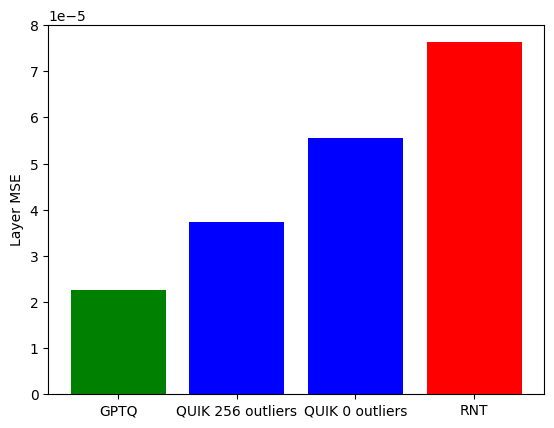

In [ ]:
fruits = ['GPTQ', 'QUIK 256 outliers', 'QUIK 0 outliers', 'RNT']
counts = [gptq_mse, quik_256_mse, quik_0_mse, rtn_mse]
bar_labels = ['green', 'blue', 'blue', 'red']
bar_colors = ['green', 'blue', 'blue', 'red']

plt.bar(fruits, counts, label=bar_labels, color=bar_colors)
plt.ylabel("Layer MSE")
plt.show()

As we can see, QUIK allows for errors almost as small as GPTQ, while performing the most computation-heavy matrix multiplication with quantized values. As we have seen in the seminar section, that can lead to 2x-3x speedup over `float16`.

**Check yourself:** the values should be ascending left to right.